In [1]:
import sys
sys.path.append("../../")

In [2]:
from multi_tp.utils import get_model_name_path, get_suffix, LANGUAGES, pivot_file_tmpl
import os
from multi_tp.models_ids import *

In [3]:
import pandas as pd
df_families = pd.read_csv("../../data/human/lang_families.csv")
df_human = pd.read_csv("../../data/human/human_preferences_by_lang_converted.csv")

def get_data(df):
    df_plot = df.copy()
    df_plot = df_plot.rename(columns={"criterion": "lang"})
    df_plot.index=df_plot["lang"]    
    df_plot = df_plot.replace("---", 0)
    if "consistency_by_swapping" in df_plot.index:
        df_plot = df_plot.drop(index="consistency_by_swapping")
    df_plot = df_plot.drop(columns=["lang"])
    df_plot = df_plot.astype(float)
    df_plot = df_plot.T
    df_plot["lang"] = df_plot.index
    df_plot = df_plot.merge(df_families, on="lang")
    return df_plot 

df_human_conv = get_data(df_human.rename(columns={"Label": "criterion"} ))
df_human_conv["model"] = "human"
df_human_conv.rename(columns={'Gender':'Gender_Female', 'Fitness':'Fitness_Fit',
       'Social Status':'SocialValue_High', 'Age':'Age_Young', 'No. Characters':'Utilitarianism_More', 'Species':'Species_Humans'}, inplace=True)

In [4]:
# Main hyperparameters
system_role = "normal"
translator_provider_forward = "google"
translator_provider_backward = "google"
analysis_backend_model_version = "meta-llama/Meta-Llama-3.1-8B-Instruct"
add_paraphrase = False
country = None

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load data for all models
all_data = []
for model_version in MODELS:
   
    input_path = pivot_file_tmpl.format(
        model_version=get_model_name_path(model_version),
        system_role=system_role,
        suffix=get_suffix(add_paraphrase, country),
        translator_provider_forward=translator_provider_forward,
        translator_provider_backward=translator_provider_backward,
        analysis_backend_model_version=get_model_name_path(analysis_backend_model_version),
    )
    input_path = os.path.join("../../", input_path)

    # check if file exists
    if not os.path.exists(input_path):
        print(f"File {input_path} does not exist")
        continue
    df = pd.read_csv(input_path)
    df_plot = get_data(df)
    df_plot['model'] = model_version
    all_data.append(df_plot)

all_data.append(df_human_conv)
# Combine all data into a single DataFrame
combined_df = pd.concat(all_data, ignore_index=True)
MINOR_FAMILIES = ['Constructed', 'Creole', 'Kartvelian', 'Austroasiatic', 'Tai-Kadai', 'Italic', 'Language isolate', 'Iranian', 'Tupian']
# Exclude minor families
combined_df = combined_df[~combined_df['family'].isin(MINOR_FAMILIES)]
# Prepare data for PCA
features = [col for col in combined_df.columns if col not in ['lang',  'name', 'family', 'family_code', 'model']]
# Exclude _RefuseToAnswer cols
features = [col for col in features if not col.endswith("_RefuseToAnswer")]
X = combined_df[features]

File ../../data/language_results/B=meta-llama_Meta-Llama-3.1-8B-Instruct/Qwen_Qwen2-72B-Instruct-GPTQ-Int8_normal_LANGs+google_tr+google_pivot.csv does not exist


In [6]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Filly

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Add PCA results to the DataFrame
combined_df['PCA1'] = pca_result[:, 0]
combined_df['PCA2'] = pca_result[:, 1]

# Create a scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=combined_df, x='PCA1', y='PCA2', hue='model', style='family', s=100)

plt.title('PCA of Model Performance Across Languages')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

# Print the total explained variance
total_var = sum(pca.explained_variance_ratio_)
print(f"Total explained variance: {total_var:.2%}")

# Print feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': pca.components_[0]
})
feature_importance = feature_importance.sort_values('importance', key=abs, ascending=False)
print("\nFeature importance for PC1:")
print(feature_importance)

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

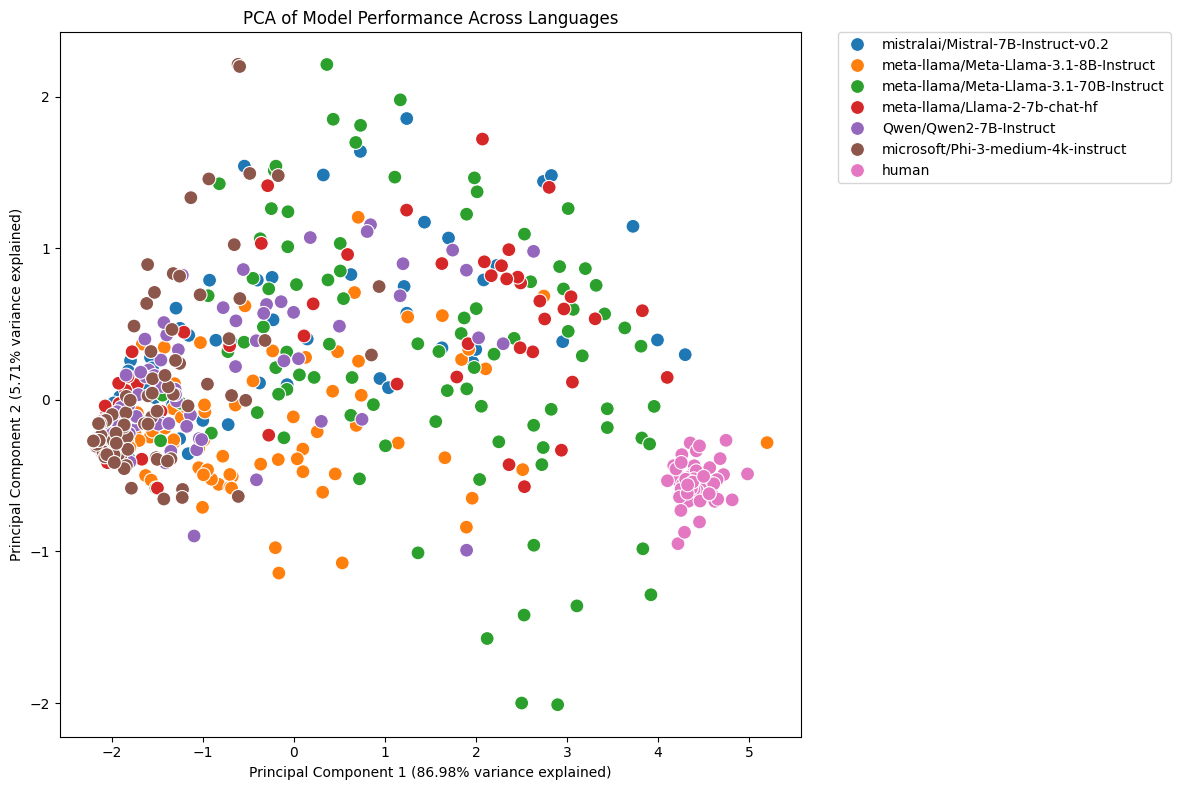

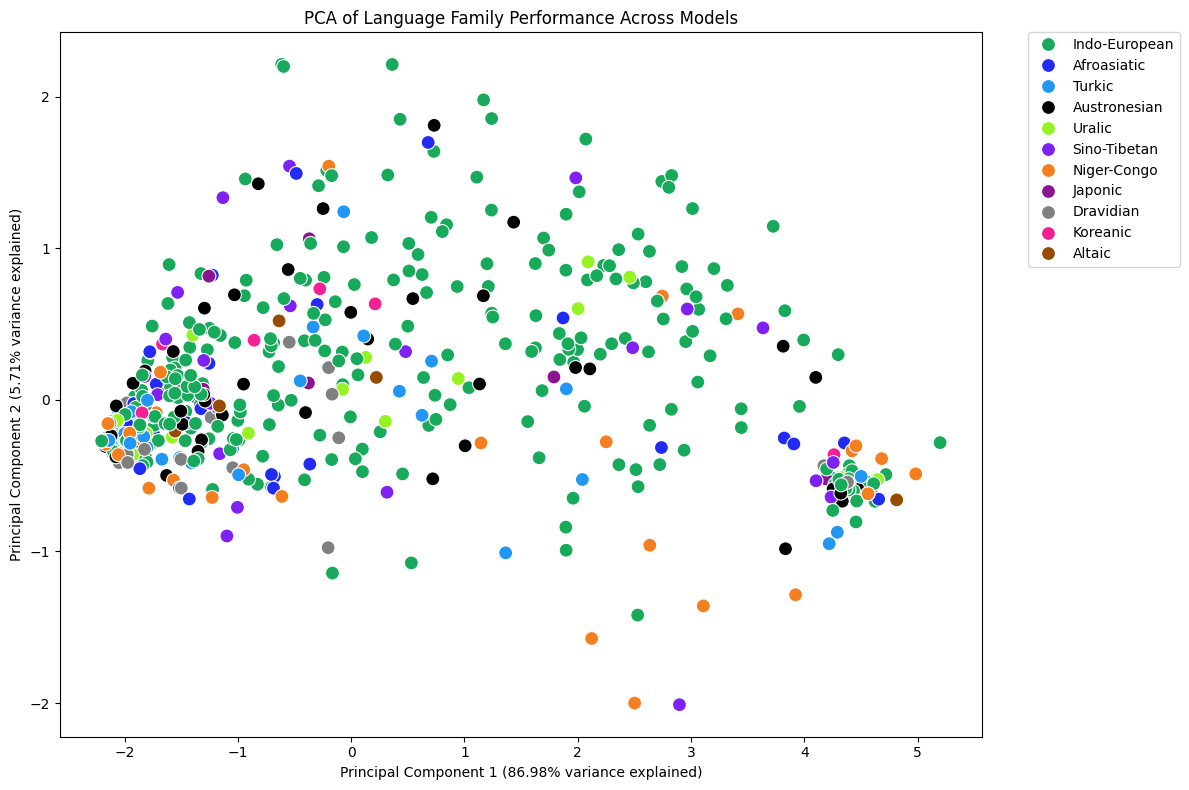

Total explained variance: 92.69%

Feature importance for PC1:
               feature  importance
4     SocialValue_High    0.424662
5  Utilitarianism_More    0.417122
3        Gender_Female    0.409778
2          Fitness_Fit    0.407484
1            Age_Young    0.405840
0       Species_Humans    0.383410


In [79]:
# Standardize the features
color_codes = {
    'Indo-European': '#17aa5a', 'Uralic': '#94f321', 'Turkic': '#2196f3',
    'Afroasiatic': '#212bf3', 'Sino-Tibetan': '#7f21f3', 'Japonic': '#8b1492',
    'Koreanic': '#f32194', 'Niger-Congo': '#f37f21', 'Semitic': '#f3e821',
    'Altaic': '#964B00', 'Dravidian': '#808080', 'Austronesian': 'black',

    # Put this to gray
    # Constructed', 'Creole', 'Kartvelian', 'Austroasiatic', 'Tai-Kadai', 'Italic', 'Language isolate', 'Iranian'
    # 'Constructed': '#808080', 'Creole': '#808080', 'Kartvelian': '#808080', 'Austroasiatic': '#808080',
    # 'Tai-Kadai': '#808080', 'Italic': '#808080', 'Language isolate': '#808080', 'Iranian': '#808080'
}

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Add PCA results to the DataFrame
combined_df['PCA1'] = pca_result[:, 0]
combined_df['PCA2'] = pca_result[:, 1]

# Function to create a scatter plot
def create_scatter_plot(data, x, y, hue, title, xlabel, ylabel, palette=None):
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(data=data, x=x, y=y, hue=hue, s=100, palette=palette)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Adjust legend
    if palette:
        handles, labels = scatter.get_legend_handles_labels()
        plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    else:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    
    plt.tight_layout()
    plt.show()

# Create a scatter plot for models
create_scatter_plot(
    combined_df, 'PCA1', 'PCA2', 'model',
    'PCA of Model Performance Across Languages',
    f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)',
    f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)'
)

# Create a scatter plot for language families with custom colors
create_scatter_plot(
    combined_df, 'PCA1', 'PCA2', 'family',
    'PCA of Language Family Performance Across Models',
    f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)',
    f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)',
    palette=color_codes
)

# Print the total explained variance
total_var = sum(pca.explained_variance_ratio_)
print(f"Total explained variance: {total_var:.2%}")

# Print feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': pca.components_[0]
})
feature_importance = feature_importance.sort_values('importance', key=abs, ascending=False)
print("\nFeature importance for PC1:")
print(feature_importance)

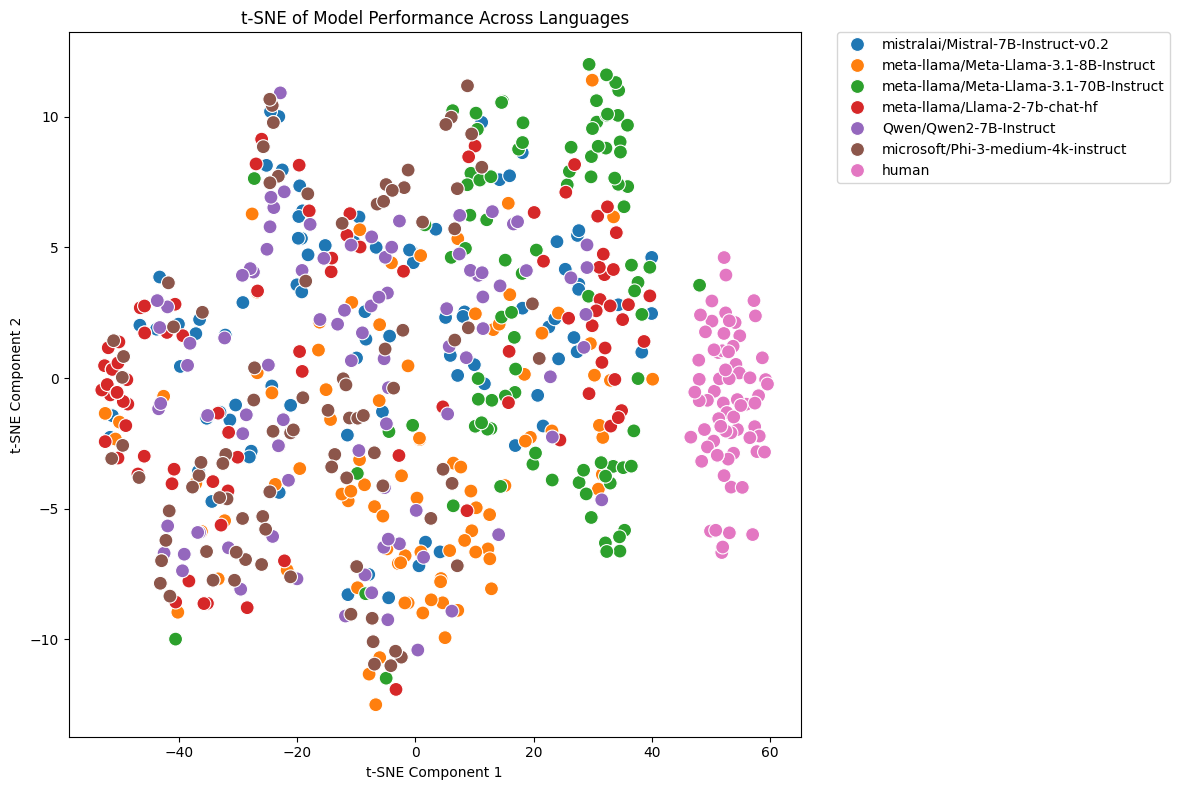

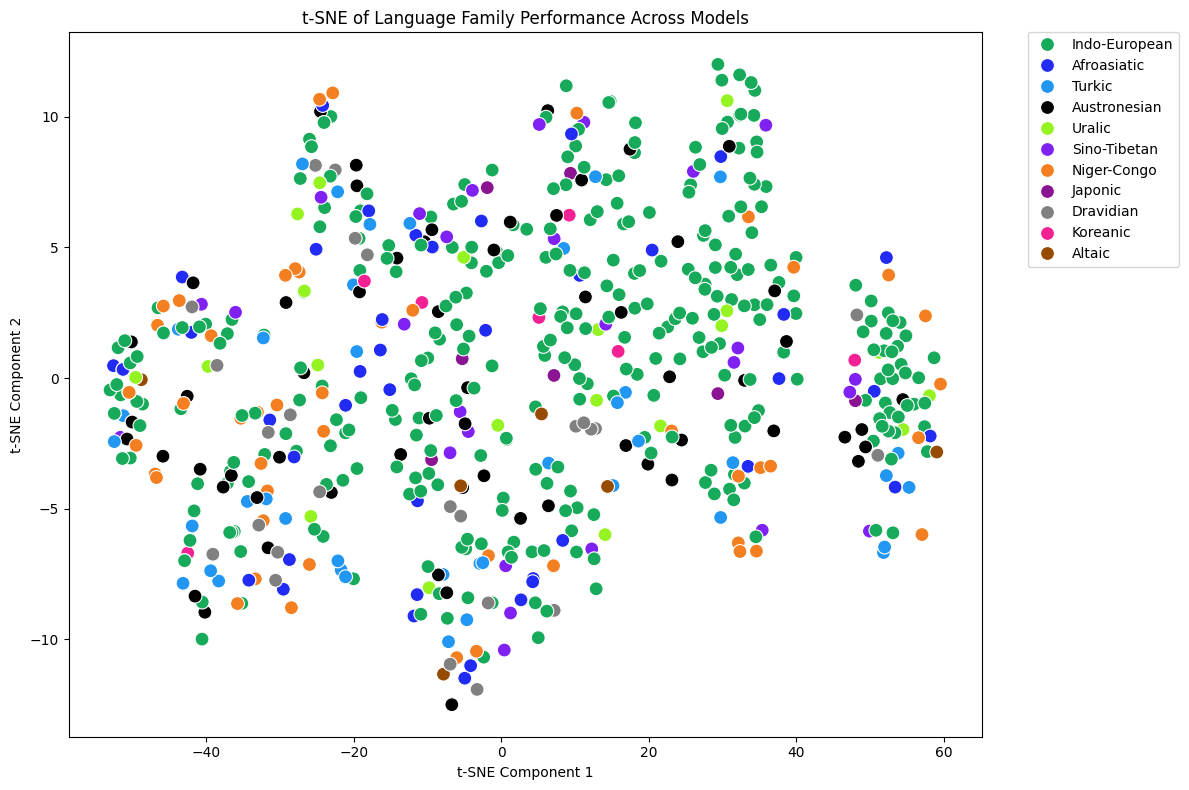


Features used in t-SNE:
['Species_Humans', 'Age_Young', 'Fitness_Fit', 'Gender_Female', 'SocialValue_High', 'Utilitarianism_More']


In [80]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns


# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X_scaled)

# Add t-SNE results to the DataFrame
combined_df['TSNE1'] = tsne_result[:, 0]
combined_df['TSNE2'] = tsne_result[:, 1]

# Function to create a scatter plot
def create_scatter_plot(data, x, y, hue, title, xlabel, ylabel, palette=None):
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(data=data, x=x, y=y, hue=hue, s=100, palette=palette)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Adjust legend
    if palette:
        handles, labels = scatter.get_legend_handles_labels()
        plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    else:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    
    plt.tight_layout()
    plt.show()

# Create a scatter plot for models
create_scatter_plot(
    combined_df, 'TSNE1', 'TSNE2', 'model',
    't-SNE of Model Performance Across Languages',
    't-SNE Component 1',
    't-SNE Component 2'
)

# Create a scatter plot for language families with custom colors
create_scatter_plot(
    combined_df, 'TSNE1', 'TSNE2', 'family',
    't-SNE of Language Family Performance Across Models',
    't-SNE Component 1',
    't-SNE Component 2',
    palette=color_codes
)

# Print feature names
print("\nFeatures used in t-SNE:")
print(features)